# SPSS Modelerのバランス・ノードをPythonで書き換える。


■利用データ<BR>
ローン審査での、顧客の属性と判定したリスクの入ったデータを使います。Riskが１の場合はリスクの高い顧客、0はリスクの低い顧客を示しています。データには欠損値が含まれています。

CustID:顧客番号
Age:年齢
Car_loans：車のローンランク
Credit_cards:クレジットカード利用ランク
Education:教育ランク
Income:収入ランク
Risk:リスクありなし
![image.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/223763/eb1c3f47-b286-4222-df8b-ae783f97eea3.png)


In [1]:
!wget https://github.com/hkwd/200611Modeler2Python/raw/master/data/credit_risk_missing.csv

'wget' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [2]:
#データの読み込み
import types
import pandas as pd

pd.options.display.max_rows = 100
#print(pd.options.display.max_rows)

import pandas as pd
df = pd.read_csv('credit_risk_missing.csv',dtype = {'CustID':'int', 'Age':'float', 'Car_loans':'category','Credit_cards':'category',
                                                    'Education':'category','Income':'category','Risk':'category'}
                , quotechar='\'')
print(df.dtypes)
df.head(10)


CustID             int32
Age              float64
Car_loans       category
Credit_cards    category
Education       category
Income          category
Risk            category
dtype: object


,CustID,Age,Car_loans,Credit_cards,Education,Income,Risk
0,1,28.0,1,1,2,3,0
1,2,45.0,2,2,2,2,1
2,3,23.0,1,1,1,2,0
3,4,NaN,1,1,2,2,0
4,5,27.0,1,1,1,2,0
5,6,25.0,NaN,1,1,3,0
6,7,39.0,1,NaN,1,3,0
7,8,150.0,2,1,NaN,3,1
8,9,37.0,1,1,NaN,NaN,0
9,10,38.0,1,1,,3,0


pandasでデータを読み込むときに気を付けること(dtypeの指定) - Qiita https://qiita.com/haru1977/items/53c582eb9e264ccf8574

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

ipython-notebook — ipythonノートブック出力ウィンドウのサイズを変更します
https://www.webdevqa.jp.net/ja/ipython-notebook/ipython%E3%83%8E%E3%83%BC%E3%83%88%E3%83%96%E3%83%83%E3%82%AF%E5%87%BA%E5%8A%9B%E3%82%A6%E3%82%A3%E3%83%B3%E3%83%89%E3%82%A6%E3%81%AE%E3%82%B5%E3%82%A4%E3%82%BA%E3%82%92%E5%A4%89%E6%9B%B4%E3%81%97%E3%81%BE%E3%81%99/1041963108/

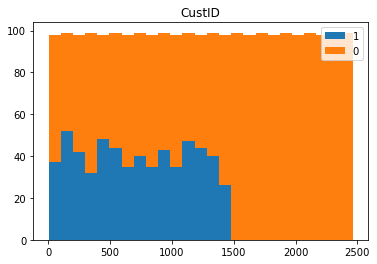

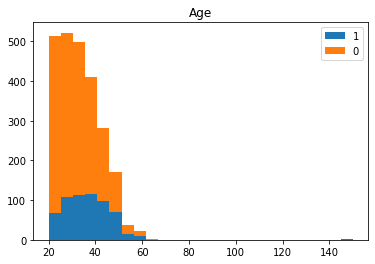

<Figure size 432x288 with 0 Axes>

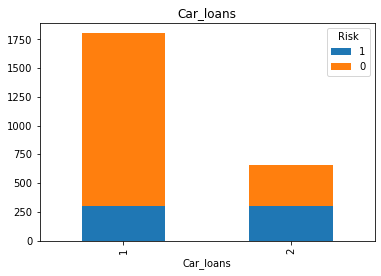

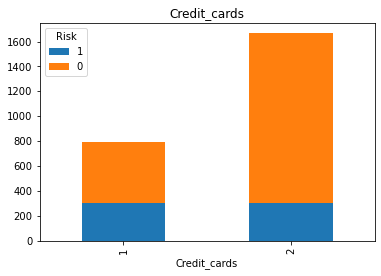

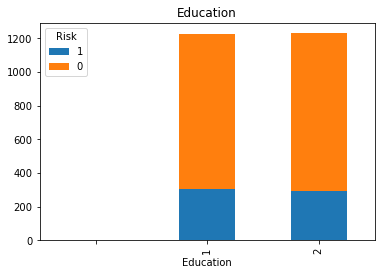

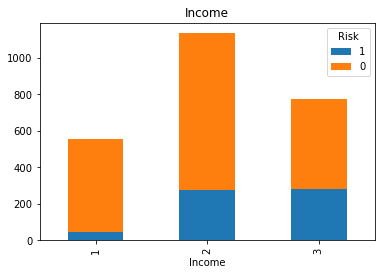

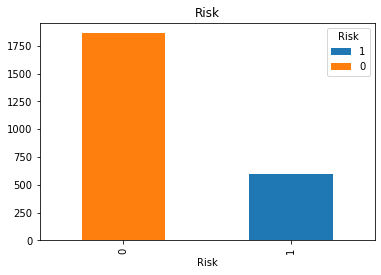

In [5]:

#度数棒グラフとヒストグラム
import re

targetcol='Risk'
for col in df.columns:
    
    if df[col].dtype.name=='category':
        dfcross=pd.crosstab(df[col],df[targetcol])
        dfcross=dfcross.reindex(['1','0'],axis="columns")
        dfcross.plot.bar(stacked=True,title=col)
    elif re.sub(r'[0-9]+', '', df[col].dtype.name) in ['int','float']:
        nums=[]
        targets=df[targetcol].cat.categories.sort_values (ascending=False)
        for i,target in enumerate(targets):
            nums.append(df.query(targetcol+'==\'{0}\''.format(target))[col])
        plt.title(col)
        plt.hist(nums,bins=25, stacked=True,label=targets.astype('str'))
        plt.legend()
        plt.figure()

    

python - Check if dataframe column is Categorical - Stack Overflow
https://stackoverflow.com/questions/26924904/check-if-dataframe-column-is-categorical

    Python で文字列から数字を削除する | Delft スタック https://www.delftstack.com/ja/howto/python/remove-numbers-from-string-python/

In [6]:
df.describe()

,CustID,Age
count,2464.000000,2461.000000
mean,1232.500000,33.351077
std,711.439855,8.859350
min,1.000000,20.000000
25%,616.750000,26.000000
50%,1232.500000,33.000000
75%,1848.250000,39.000000
max,2464.000000,150.000000


In [7]:
#歪度
df.skew()

CustID          0.000000
Age             1.348553
Car_loans       1.050147
Credit_cards   -0.755945
Income         -0.140252
Risk            1.195325
dtype: float64

pandasで歪度(Skewness)と尖度(Kurtosis)を計算 - Qiita https://qiita.com/ymmy02/items/36e708d3d9e5e4e6a457

In [8]:
#カテゴリ数
df.nunique()

CustID          2464
Age               45
Car_loans          2
Credit_cards       2
Education          3
Income             3
Risk               2
dtype: int64

In [9]:
#外れ値、極値
df1 = pd.DataFrame(index=[], columns=['外れ値','極値'])
for col in df.columns:
    if re.sub(r'[0-9]+', '', df[col].dtype.name) in ['int','float']:
        limit_low3=df[col].mean()-df[col].std()*3
        limit_high3=df[col].mean()+df[col].std()*3
        limit_low5=df[col].mean()-df[col].std()*5
        limit_high5=df[col].mean()+df[col].std()*5
        hazurechi=((df[col] <limit_low3)|(df[col] >limit_high3)).sum()
        kyokuchi=((df[col] <limit_low5)|(df[col] >limit_high5)).sum()
        df1=df1.append(pd.Series([hazurechi-kyokuchi,kyokuchi],index=df1.columns,name=col))
df1

,外れ値,極値
CustID,0,0
Age,4,1


Python初心者向け：四分位数/標準偏差を用いた外れ値の除外 | happy analysis https://happy-analysis.com/python/python-topic-outlier.html
    Pandasにて条件にあったカウント（count）を行う方法【value_countsの使い方など】 | ウルトラフリーダム https://life-freedom888.com/pandas-count/
    Pythonで、空のDataFrameにindexとセットで1行追加する | ITを使っていこう https://it-ojisan.tokyo/python-dataframe-append/

In [10]:
#欠損値
df.isnull().sum()

CustID          0
Age             3
Car_loans       2
Credit_cards    2
Education       4
Income          2
Risk            1
dtype: int64

In [11]:
#欠損値
colnames=['非欠損値の割合','有効なレコード','ヌル値','空文字','空白文字']
dfcol=pd.DataFrame(index=df.columns,columns=colnames)

#ヌル
for i,col in enumerate(dfcol.index):
    if df[col].dtype.name=='category':
        dfcol.iloc[i,colnames.index('ヌル値')]=0
    elif re.sub(r'[0-9]+', '', df[col].dtype.name) in ['int','float']:
        dfcol.iloc[i,colnames.index('ヌル値')]=df[col].isnull().sum()
#空文字列
for i,col in enumerate(dfcol.index):
    if df[col].dtype.name=='category':
        dfcol.iloc[i,colnames.index('空文字')]=df[col].isnull().sum()
    elif re.sub(r'[0-9]+', '', df[col].dtype.name) in ['int','float']:
        dfcol.iloc[i,colnames.index('空文字')]=0
#空白文字
for i,col in enumerate(dfcol.index):
    if df[col].dtype.name=='category':
        dfcol.iloc[i,colnames.index('空白文字')]=((df[col].str.match(r'^ +$'))).sum()+dfcol.iloc[i,colnames.index('空文字')]
    elif re.sub(r'[0-9]+', '', df[col].dtype.name) in ['int','float']:
        dfcol.iloc[i,colnames.index('空白文字')]=0
#有効なレコード
dfcol['有効なレコード']=len(df)-(dfcol['ヌル値']+dfcol['空白文字'])
dfcol['非欠損値の割合']=dfcol['有効なレコード']/len(df)*100
dfcol

,非欠損値の割合,有効なレコード,ヌル値,空文字,空白文字
CustID,100,2464,0,0,0
Age,99.8782,2461,3,0,0
Car_loans,99.9188,2462,0,2,2
Credit_cards,99.9188,2462,0,2,2
Education,99.7971,2459,0,4,5
Income,99.9188,2462,0,2,2
Risk,99.9594,2463,0,1,1


In [12]:
#欠損値
colnames=['非欠損値の割合','有効なレコード','ヌル値','空文字','空白文字']
dfcol=pd.DataFrame(index=df.columns,columns=colnames)

#ヌル
for i,col in enumerate(dfcol.index):
    if df[col].dtype.name=='category':
        dfcol.iloc[i,colnames.index('ヌル値')]=0
    elif re.sub(r'[0-9]+', '', df[col].dtype.name) in ['int','float']:
        dfcol.iloc[i,colnames.index('ヌル値')]=df[col].isnull().sum()
#空文字列
for i,col in enumerate(dfcol.index):
    if df[col].dtype.name=='category':
        dfcol.iloc[i,colnames.index('空文字')]=df[col].isnull().sum()
    elif re.sub(r'[0-9]+', '', df[col].dtype.name) in ['int','float']:
        dfcol.iloc[i,colnames.index('空文字')]=0
#空白文字
for i,col in enumerate(dfcol.index):
    if df[col].dtype.name=='category':
        dfcol.iloc[i,colnames.index('空白文字')]=((df[col].str.match(r'^ +$'))).sum()+dfcol.iloc[i,colnames.index('空文字')]
    elif re.sub(r'[0-9]+', '', df[col].dtype.name) in ['int','float']:
        dfcol.iloc[i,colnames.index('空白文字')]=0
#有効なレコード
dfcol['有効なレコード']=len(df)-(dfcol['ヌル値']+dfcol['空白文字'])
dfcol['非欠損値の割合']=dfcol['有効なレコード']/len(df)*100
dfcol

,非欠損値の割合,有効なレコード,ヌル値,空文字,空白文字
CustID,100,2464,0,0,0
Age,99.8782,2461,3,0,0
Car_loans,99.9188,2462,0,2,2
Credit_cards,99.9188,2462,0,2,2
Education,99.7971,2459,0,4,5
Income,99.9188,2462,0,2,2
Risk,99.9594,2463,0,1,1


In [13]:
import sys

print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [14]:
print(pd.__version__)

1.0.5
